In [ ]:
# !pip install mysql-connector-python

In [151]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder

import os 

In [152]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [153]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_27440\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_27440\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_27440\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


### data preprocessing

In [155]:
# Syncronize column about wisata_id between dataframe destination & ratings
destination = destination.rename(columns={'id' : 'wisata_id'})

In [156]:
destination.head(2)

,wisata_id,name_wisata,description_wisata,category,destination_photo,city,price,rating,time_minutes,coordinate,destination_lat,destination_long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,lala.png,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.17539,106.8272
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,lala.png,Jakarta,5000.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.13764,106.8171


In [157]:
ratings.head(2)

,user_wisata,wisata_id,wisata_rating
0,1,179,3.0
1,1,344,2.0


In [165]:
# Merge dataframe ratings & destination
merged_df = pd.merge(ratings, destination[['wisata_id', 'name_wisata', 'category', 'description_wisata', 'destination_lat', 'destination_long', 'destination_photo', 'city']], on='wisata_id', how='left')

In [166]:
# Remove duplicates wisata_id & user_wisata
merged_df = merged_df.sort_values('wisata_rating', ascending=False).drop_duplicates(subset=['wisata_id', 'user_wisata'], keep='first')

In [167]:
merged_df.head(2)

,user_wisata,wisata_id,wisata_rating,name_wisata,category,description_wisata,destination_lat,destination_long,destination_photo,city
7644,230,396,5.0,Monumen Kapal Selam,Budaya,"Monumen Kapal Selam, atau disingkat Monkasel, ...",-7.26543,112.7503,lala.png,Surabaya
8383,253,117,5.0,The World Landmarks - Merapi Park Yogyakarta,Taman Hiburan,Merapi Park merupakan salah satu tempat wisata...,-7.62090,110.4216,lala.png,Yogyakarta


In [169]:
merged_df.shape

(9597, 10)

## Modeling

In [170]:
# Encode user and place IDs
user_encoder = LabelEncoder()
place_encoder = LabelEncoder()

merged_df['user_wisata'] = user_encoder.fit_transform(merged_df['user_wisata'])
merged_df['wisata_id'] = place_encoder.fit_transform(merged_df['wisata_id'])

In [172]:
# Split data into training and validation/test
train, test = train_test_split(merged_df, test_size = 0.2, random_state=42)

In [173]:
# training data 
train_user = train['user_wisata'].values
train_place = train['wisata_id'].values
train_labels = train['wisata_rating'].values

In [174]:
# validation/ test 
val_user = test['user_wisata'].values
val_place = test['wisata_id'].values
val_labels = test['wisata_rating'].values

In [175]:
## NOTES 
# x = user_id, place_id 
# y = place_ratings 

In [176]:
# check the size of train and test 
print(f'train shape = {train.shape}')
print(f'test shape = {test.shape}')

train shape = (7677, 10)
test shape = (1920, 10)


In [177]:
number_user = len(merged_df['user_wisata'].unique())
number_destination = len(merged_df['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [178]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [179]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [180]:
history = model.fit([train_place, train_user], train_labels, validation_data=([val_place, val_user], val_labels), 
                    epochs=100, callbacks=[early_stopping])

Epoch 1/100
240/240 [==============================] - 2s 3ms/step - loss: 11.4849 - val_loss: 11.5364
Epoch 2/100
240/240 [==============================] - 1s 2ms/step - loss: 11.4575 - val_loss: 11.5303
Epoch 3/100
240/240 [==============================] - 1s 2ms/step - loss: 11.4099 - val_loss: 11.4986
Epoch 4/100
240/240 [==============================] - 1s 2ms/step - loss: 11.2941 - val_loss: 11.3768
Epoch 5/100
240/240 [==============================] - 0s 2ms/step - loss: 11.0188 - val_loss: 11.0442
Epoch 6/100
240/240 [==============================] - 0s 2ms/step - loss: 10.4532 - val_loss: 10.3753
Epoch 7/100
240/240 [==============================] - 0s 2ms/step - loss: 9.5031 - val_loss: 9.3267
Epoch 8/100
240/240 [==============================] - 0s 2ms/step - loss: 8.2315 - val_loss: 8.0052
Epoch 9/100
240/240 [==============================] - 1s 2ms/step - loss: 6.7921 - val_loss: 6.5854
Epoch 10/100
240/240 [==============================] - 1s 2ms/step - loss: 5.3

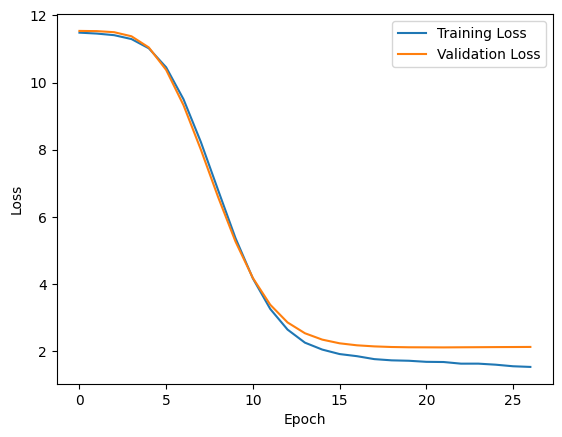

In [181]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [182]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [217]:

# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, u_lat, u_long, np_val = 6):
    """
        User_Id : untuk melakukan rekomendasi berdasarkan User_Id yang diberikan
        destinatin : dataframe dengan format column terdapat "user_wisata, wisata_id, wisata_rating, name_wisata, category, description_wisata, destination_lat, destination_long, destination_photo, city"
        model : model hasil yang sudah di training sebelumnya
        np_val : banyaknya output yang akan diberikan
        u_lat & u_long : berguna untuk menentukan destinasi wisata terdekat dari lat & long yang diberikan
    """
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.wisata_id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = filter_by_location(destination, u_lat, u_long, 30)[:20]
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)

    return destination[['name_wisata', 'city', 'destination_photo','description_wisata', 'predicted_rating', 'destination_lat', 'destination_long']][:np_val].to_dict(orient='records')

## Model result

In [220]:
user_location = 'Bandung'
user_lat = -6.1253
user_long = 106.8335

In [221]:
final_result = collaborative_rec(34, merged_df, model, user_lat, user_long, 5)
final_result

[{'name_wisata': 'Perpustakaan Nasional',
  'city': 'Jakarta',
  'destination_photo': 'lala.png',
  'description_wisata': 'Perpustakaan Nasional adalah perpustakaan yang secara khusus didirikan oleh Pemerintah Negara demi menyimpan informasi negara tersebut. Berbeda dengan perpustakaan umum, sangatlah jarang khalayak ramai diperbolehkan meminjam buku. Seringkali sebuah perpus',
  'predicted_rating': 3.6844482421875,
  'destination_lat': -6.18129,
  'destination_long': 106.8269},
 {'name_wisata': 'Kidzania',
  'city': 'Jakarta',
  'destination_photo': 'lala.png',
  'description_wisata': 'KidZania adalah sebuah waralaba swasta Meksiko berupa pusat hiburan keluarga yang saat ini beroperasi di 23 lokasi, yang memungkinkan anak-anak melakukan pekerjaan orang dewasa dan mendapat bayaran. KidZania telah dikunjungi oleh lebih dari 31 juta pengun',
  'predicted_rating': 3.546159029006958,
  'destination_lat': -6.22507,
  'destination_long': 106.8097},
 {'name_wisata': 'Rumah Sipitung',
  'city'

## Pretraining model

In [186]:
tf.keras.models.save_model(model, 'pretrained_collab_rec')

INFO:tensorflow:Assets written to: pretrained_collab_rec\assets


INFO:tensorflow:Assets written to: pretrained_collab_rec\assets


In [187]:
# Example of loading pretrained model

loaded_model =  tf.keras.models.load_model('pretrained_collab_rec')

pretrained_result = collaborative_rec(34, destination, loaded_model, 5, user_lat, user_long)
print(pretrained_result==final_result)

False


In [188]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        21900       ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        15050       ['input_14[0][0]']               
                                                                                            

In [189]:
loaded_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        21900       ['input_13[0][0]']               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        15050       ['input_14[0][0]']               
                                                                                            